# Kraków air pollution

The aim of this notebook is to predict the air pollution of Kraków, Poland.
I decided to work on this issue since it is the city where I live and it is the massive issue of this city.

This project is as well done in the context of the Zero-to-GANs Deeplearning boot camp provided by [Jovian.ml](https://jovian.ml/) and [freecodecamp.org](https://www.freecodecamp.org/) as my end of bootcamp project.

Before we start, we need to define the problem. In general when we talk about the air quality we do talk about PM10 and PM2.5, PM stands for Particulate Matter. PM10 is particulate matter 10 micrometers or less in diameter, PM2.5 is particulate matter 2.5 micrometers or less in diameter.
We also need to add this information: "Particles of any substances that are less than 10 or 2.5 micrometres diameter. Particles in this size range make up a large proportion of dust that can be drawn deep into the lungs. Larger particles tend to be trapped in the nose, mouth or throat."

Source from the Australian government: [here](http://www.npi.gov.au/resource/particulate-matter-pm10-and-pm25#:~:text=PM10%20is%20particulate%20matter,be%20placed%20on%20its%20width)

### Looking for the data
We do need to look for data containing PM10 and PM2.5 of the previous years (possibily per day) and for the city of Kraków.

After a few Google Search, I have found some data [here](https://aqicn.org/data-platform/register/), they are working with [WHO](http://www.who.int/en/) and other organization, so the data sound pretty legit to me.

In [215]:
!pip install jovian --upgrade --quiet

In [216]:
import jovian

In [217]:
PROJECT_NAME = 'krakow-air-pollution'
jovian.commit(project=PROJECT_NAME)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/tsi-bouron/krakow-air-pollution


<IPython.core.display.Javascript object>

### Checking the data
Let's check the data in order to see if we need to clean them. On the link from aqicn.org given previously I had to choose a station (sensor), I decided to choose Dietla, since it is more or less in the center of Kraków.

In [204]:
!conda install numpy pandas pytorch cpuonly -c pytorch -y --quiet

Solving environment: ...working... ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



In [218]:
import pandas as pd
import numpy as np

In [219]:
DATA_FILENAME = "../input/krakowdieltaairquality/krakow-dietla-air-quality.csv"

dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.columns = ['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
num_rows_raw = dataframe_raw.shape[0]

print(num_rows_raw)
dataframe_raw.head()

1630


,date,pm25,pm10,o3,no2,so2,co
0,2020/6/1,29,16,31,8,1,4
1,2020/6/2,37,37,28,13,1,4
2,2020/6/3,51,29,35,14,,5
3,2020/6/4,54,16,25,15,1,5
4,2020/6/5,34,10,25,9,1,4


In [220]:
# Cleaning the data
dataframe = dataframe_raw.copy(deep=True)
dataframe.replace(" ", np.nan, inplace=True)
dataframe.dropna(subset=["pm25", "pm10"], inplace=True)

In [221]:
num_rows = dataframe.shape[0]
print(num_rows)
dataframe.head()

748


,date,pm25,pm10,o3,no2,so2,co
0,2020/6/1,29,16,31,8,1,4
1,2020/6/2,37,37,28,13,1,4
2,2020/6/3,51,29,35,14,NaN,5
3,2020/6/4,54,16,25,15,1,5
4,2020/6/5,34,10,25,9,1,4


In [222]:
# Check if the columns have the correct types
print(dataframe.dtypes)

date    object
pm25    object
pm10    object
o3      object
no2     object
so2     object
co      object
dtype: object


In [223]:
# Set the correct types to the column we are going to use
dataframe['date'] = pd.to_datetime(dataframe['date'], format='%Y/%m/%d')
dataframe = dataframe.astype({'pm25': 'int32', 'pm10': 'int32'})
print(dataframe.dtypes)

date    datetime64[ns]
pm25             int32
pm10             int32
o3              object
no2             object
so2             object
co              object
dtype: object


In [224]:
# Sort data per date
dataframe.sort_values(by=['date'])

,date,pm25,pm10,o3,no2,so2,co
708,2018-05-15,66,31,11,19,2,5
709,2018-05-16,70,28,19,16,NaN,4
710,2018-05-17,51,14,25,13,NaN,4
711,2018-05-18,85,36,35,12,1,4
712,2018-05-19,60,32,42,15,1,4
...,...,...,...,...,...,...,...
21,2020-06-22,48,13,30,6,NaN,3
22,2020-06-23,33,20,19,9,NaN,4
23,2020-06-24,56,22,30,12,NaN,4
24,2020-06-25,62,20,29,13,NaN,5


In [225]:
min_pm_25 = dataframe['pm25'].min()
max_pm_25 = dataframe['pm25'].max()
min_pm_10 = dataframe['pm10'].min()
max_pm_10 = dataframe['pm10'].max()
print('Minimum value of pm25:', min_pm_25)
print('Maximum value of pm25:', max_pm_25)
print('Minimum value of pm10:', min_pm_10)
print('Maximum value of pm10:', max_pm_10)

Minimum value of pm25: 14
Maximum value of pm25: 297
Minimum value of pm10: 7
Maximum value of pm10: 99


In [226]:
!pip install matplotlib seaborn --quiet

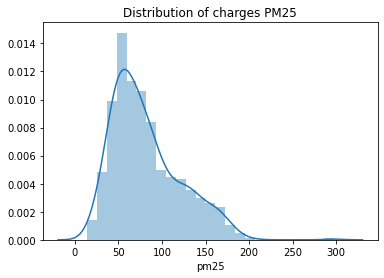

In [227]:
# Distribution of PM25 in a graph
import seaborn as sns
plt.title("Distribution of charges PM25")
sns.distplot(dataframe['pm25']);

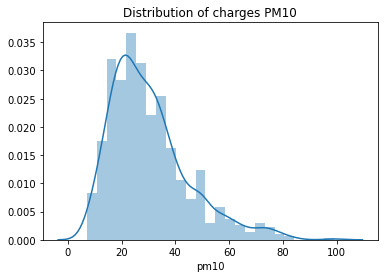

In [228]:
# Distribution of PM10 in a graph
plt.title("Distribution of charges PM10")
sns.distplot(dataframe['pm10']);

## Preparing the data for training
Now we do know how our data look like, we are going to prepare them for the training.
Which means, we will convert the data from the Pandas dataframe into a PyTorch tensors.

In [229]:
input_cols = ['date']
output_cols = ['pm25', 'pm10']
categorical_cols = ['date']
print('Inputs are: ', input_cols, ' Outputs are: ', output_cols)
print('Non-nymeruc categorical columns are: ', categorical_cols)

Inputs are:  ['date']  Outputs are:  ['pm25', 'pm10']
Non-nymeruc categorical columns are:  ['date']


In [230]:
# Convert dataframe to numpy arrays
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [231]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[722],
        [723],
        [724],
        [725],
        [726],
        [727],
        [728],
        [729],
        [730],
        [731],
        [732],
        [733],
        [734],
        [735],
        [736],
        [737],
        [738],
        [739],
        [740],
        [741],
        [742],
        [743],
        [744],
        [745],
        [746],
        [747],
        [692],
        [693],
        [694],
        [695],
        [696],
        [697],
        [698],
        [699],
        [700],
        [701],
        [702],
        [703],
        [704],
        [705],
        [706],
        [707],
        [708],
        [709],
        [710],
        [711],
        [712],
        [713],
        [714],
        [715],
        [716],
        [717],
        [718],
        [719],
        [720],
        [721],
        [662],
        [663],
        [664],
        [665],
        [666],
        [667],
        [668],
        [669],
        [670],
        [671],
        [6

In [232]:
import torch

data_type = torch.float32
inputs = torch.from_numpy(inputs_array).type(data_type)
targets = torch.from_numpy(targets_array).type(data_type)

print(inputs.dtype, targets.dtype)

torch.float32 torch.float32


We are now going to create PyTorch datasets & data loaders for training & validation. 

In [299]:
from torch.utils.data import DataLoader, TensorDataset, random_split

dataset = TensorDataset(inputs, targets)
val_percent = 0.1 #precentage of data used for the validation set
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [300]:
batch_size = 512

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [301]:
# Checking if the batch of data is working fine so far.
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[ 18.],
        [718.],
        [519.],
        [594.],
        [364.],
        [ 19.],
        [139.],
        [ 48.],
        [368.],
        [ 92.],
        [ 83.],
        [313.],
        [328.],
        [440.],
        [652.],
        [144.],
        [686.],
        [385.],
        [315.],
        [ 31.],
        [631.],
        [694.],
        [ 85.],
        [324.],
        [619.],
        [331.],
        [503.],
        [ 16.],
        [632.],
        [646.],
        [637.],
        [709.],
        [113.],
        [513.],
        [219.],
        [318.],
        [606.],
        [304.],
        [ 10.],
        [  0.],
        [246.],
        [283.],
        [483.],
        [353.],
        [398.],
        [361.],
        [258.],
        [146.],
        [566.],
        [551.],
        [705.],
        [117.],
        [109.],
        [190.],
        [679.],
        [ 98.],
        [713.],
        [556.],
        [389.],
        [363.],
        [ 51.],
        [688.],


In [269]:
jovian.commit(project=PROJECT_NAME)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/tsi-bouron/krakow-air-pollution


<IPython.core.display.Javascript object>

## Creating the Model

This model might be working with a simple linear regression model, let's start to solve this issue with a linear regression.

In [302]:
input_size = len(input_cols)
output_size = len(output_cols)
print('input_size: ', input_size)
print('output_size: ', output_size)

input_size:  1
output_size:  2


In [303]:
import torch.nn as nn
import torch.nn.functional as F

class PollutionModelLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)
        # Calcuate loss
        loss = F.mse_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.mse_loss(out, targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [304]:
model = PollutionModelLinear()

In [273]:
jovian.commit(project=PROJECT_NAME)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/tsi-bouron/krakow-air-pollution


<IPython.core.display.Javascript object>

## Train the model to fit the data

In [305]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [306]:
result = evaluate(model, val_loader)
print('Calulcated loss: ', result['val_loss'])

Calulcated loss:  90472.3046875


In [307]:
epochs = 1500
lr = 1e-8
history = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 78205.8594
Epoch [40], val_loss: 67615.2578
Epoch [60], val_loss: 58486.4453
Epoch [80], val_loss: 50580.9102
Epoch [100], val_loss: 43809.2383
Epoch [120], val_loss: 37984.1406
Epoch [140], val_loss: 32947.3164
Epoch [160], val_loss: 28610.9434
Epoch [180], val_loss: 24888.0684
Epoch [200], val_loss: 21682.9707
Epoch [220], val_loss: 18949.4375
Epoch [240], val_loss: 16569.7559
Epoch [260], val_loss: 14538.5459
Epoch [280], val_loss: 12776.1094
Epoch [300], val_loss: 11251.2656
Epoch [320], val_loss: 9938.4307
Epoch [340], val_loss: 8821.7783
Epoch [360], val_loss: 7843.8184
Epoch [380], val_loss: 7008.2764
Epoch [400], val_loss: 6292.0859
Epoch [420], val_loss: 5674.0952
Epoch [440], val_loss: 5141.5747
Epoch [460], val_loss: 4681.1001
Epoch [480], val_loss: 4287.4390
Epoch [500], val_loss: 3946.2146
Epoch [520], val_loss: 3652.3755
Epoch [540], val_loss: 3401.6387
Epoch [560], val_loss: 3185.9954
Epoch [580], val_loss: 2999.6833
Epoch [600], val_loss: 2840.4399

In [308]:
val_loss = history[-1]['val_loss']
print('Final validation loss: ', val_loss)

Final validation loss:  1866.77490234375


In [309]:
# This line is used to commit the metrics to Jovian
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [310]:
jovian.commit(project=PROJECT_NAME, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/tsi-bouron/krakow-air-pollution


<IPython.core.display.Javascript object>

## Test the model by making predictions using the trained model

In [311]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [312]:
for input, target in val_ds:
    predict_single(input, target, model)

Input: tensor([150.])
Target: tensor([141.,  68.])
Prediction: tensor([22.7965,  9.1486])
Input: tensor([498.])
Target: tensor([46., 29.])
Prediction: tensor([76.8971, 30.3895])
Input: tensor([284.])
Target: tensor([112.,  50.])
Prediction: tensor([43.6283, 17.3276])
Input: tensor([583.])
Target: tensor([88., 12.])
Prediction: tensor([90.1113, 35.5777])
Input: tensor([369.])
Target: tensor([76., 33.])
Prediction: tensor([56.8425, 22.5157])
Input: tensor([396.])
Target: tensor([54., 20.])
Prediction: tensor([61.0400, 24.1637])
Input: tensor([183.])
Target: tensor([84., 32.])
Prediction: tensor([27.9267, 11.1628])
Input: tensor([554.])
Target: tensor([130.,  36.])
Prediction: tensor([85.6029, 33.8076])
Input: tensor([231.])
Target: tensor([59., 32.])
Prediction: tensor([35.3888, 14.0926])
Input: tensor([539.])
Target: tensor([81., 32.])
Prediction: tensor([83.2710, 32.8920])
Input: tensor([689.])
Target: tensor([65., 29.])
Prediction: tensor([106.5902,  42.0476])
Input: tensor([195.])
Ta

In [313]:
jovian.commit(project=PROJECT_NAME, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/tsi-bouron/krakow-air-pollution


<IPython.core.display.Javascript object>